In [8]:
import csv
import pandas
import numpy
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

import csv
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
# Definisi Fungsi Keanggotaan Fuzzy
def triangular_membership(x, a, b, c):
    return max(min((x-a)/(b-a), (c-x)/(c-b)), 0)

# Fuzzifikasi untuk satu input
def fuzzify_input(x, membership_functions):
    return [mf(x) for mf in membership_functions]

In [3]:
data = []

with open('dataset.csv', mode='r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        data.append([float(row['current']), float(row['rawIntensity']), float(row['temperature']), float(row['voltage']), int(row['pwm'])])

data = numpy.array(data)

X_raw = data[:, :-1]
y = data[:, -1]

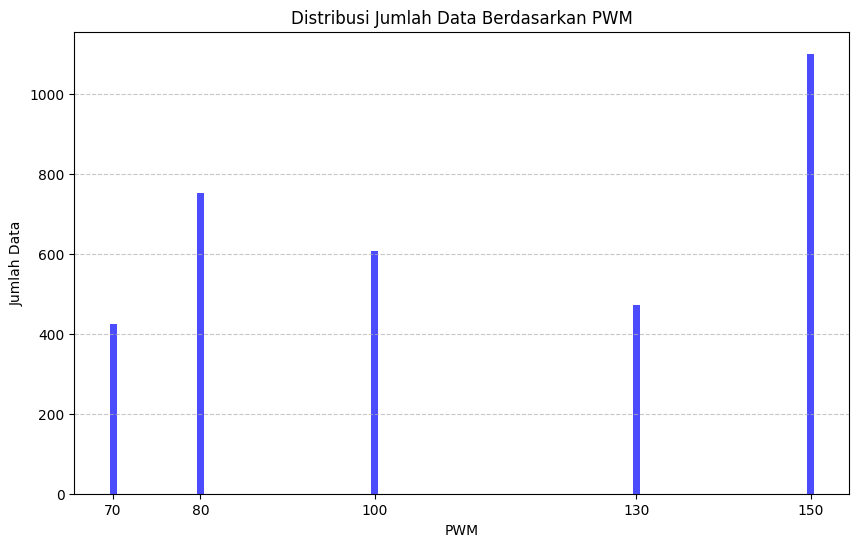

In [9]:
# Menghitung jumlah kemunculan setiap nilai PWM
pwm_values = data[:, 4]  # Kolom PWM
pwm_counts = Counter(pwm_values)

# Membuat plot
plt.figure(figsize=(10, 6))
plt.bar(pwm_counts.keys(), pwm_counts.values(), color='b', alpha=0.7)
plt.xlabel('PWM')
plt.ylabel('Jumlah Data')
plt.title('Distribusi Jumlah Data Berdasarkan PWM')
plt.xticks(sorted(pwm_counts.keys()))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [10]:
membership_functions = [
    lambda x: triangular_membership(x, 0, 25, 40),  # "current"
    lambda x: triangular_membership(x, 1000, 1010, 1020),  # "rawIntensity"
    lambda x: triangular_membership(x, 20, 25, 30),  # "temperature"
    lambda x: triangular_membership(x, 0.85, 0.9, 0.95)  # "voltage"
]

In [11]:
X_fuzzy = numpy.array([
    [fuzzify_input(x, membership_functions) for x in X_row] for X_row in X_raw
])

X_train, X_val, y_train, y_val = train_test_split(X_fuzzy.reshape(len(X_fuzzy), -1), y, test_size=0.2, random_state=42)


In [12]:
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(8, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

c:\Users\atmatech\Documents\eps32_solarcell_anfis_mppt\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=4, verbose=1)


Epoch 1/200
671/671 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1051.7350 - mae: 29.3884 - val_loss: 1019.9040 - val_mae: 29.0565
Epoch 2/200
671/671 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1014.2913 - mae: 28.9638 - val_loss: 1011.2914 - val_mae: 29.1713
Epoch 3/200
671/671 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1012.6392 - mae: 29.1381 - val_loss: 998.9674 - val_mae: 28.9793
Epoch 4/200
671/671 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1014.8268 - mae: 29.3034 - val_loss: 991.5471 - val_mae: 29.0183
Epoch 5/200
671/671 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 982.5781 - mae: 28.8357 - val_loss: 986.6437 - val_mae: 28.9621
Epoch 6/200
671/671 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 988.4343 - mae: 29.0696 - val_loss: 982.7898 - val_mae: 29.0822
Epoch 7/200
671/671 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 950.7626 - mae: 28.4712 - val_loss: 982.6119 - val_mae: 28.8551
Epoch 8/200
671/671 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 966.1016 - mae: 28.6960 - val_loss: 977.2424 - val_mae: 29

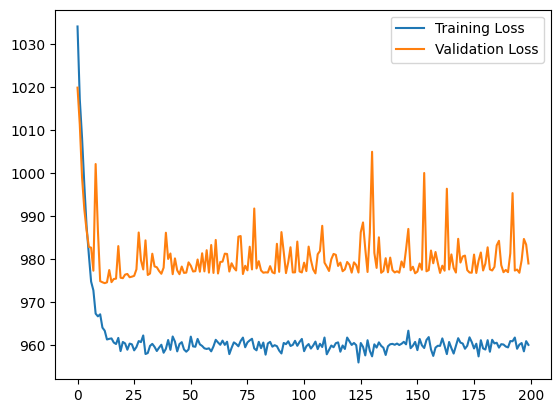

In [15]:
# Step 6: Plot Hasil
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [18]:
y_pred = model.predict(X_val)

# Menghitung metrik evaluasi
mse = mean_squared_error(y_val, y_pred)
rmse = numpy.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"R-squared (R2): {r2:.4f}")

r2_percent = r2 * 100
print(f"R-squared dalam persen: {r2_percent:.2f}%")


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
R-squared (R2): 0.0240
R-squared dalam persen: 2.40%


In [10]:
model.save('model.h5')

In [11]:
converter = tensorflow.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\atmatech\AppData\Local\Temp\tmpag8fdw9w\assets


INFO:tensorflow:Assets written to: C:\Users\atmatech\AppData\Local\Temp\tmpag8fdw9w\assets


Saved artifact at 'C:\Users\atmatech\AppData\Local\Temp\tmpag8fdw9w'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 16), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2595996212432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2595996216080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2595996214928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2595996213776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2595996216656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2595996214352: TensorSpec(shape=(), dtype=tf.resource, name=None)
